# Notebook description
2023-03-14

**Import libraries**

In [1]:
# basic stuff
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# gis stuff
# os.environ['USE_PYGEOS'] = '0' # pygeos/shapely2.0/osmnx conflict solving
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, LineString


/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_32732/1165161682.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


**Create folders and load region polygons**

In [2]:
os.makedirs("../results", exist_ok=True)
os.makedirs("../results/23-03-14-evaluation", exist_ok=True)

In [2]:
regions = ["stevns", "skjern", "aabenraa"]
regions_coldict = {regions[0]: "green", regions[1]: "blue", regions[2]: "orange"}
regions_dict = {}

for region in regions:
    regions_dict[region] = {}
    regions_dict[region]["region"] = gpd.read_file(f"../data/processed/{region}/region.gpkg")
    regions_dict[region]["edges"] = gpd.read_file(f"../data/processed/{region}/edges.gpkg")

**Process point data**

In [24]:
# evaluate and save as gpkg for viz
pointtypes = ["attraktioner", "faciliteter"]

for region in regions:
    for pointtype in pointtypes:
        mypoints = gpd.read_file(f"../data/processed/{region}/point/{pointtype}.gpkg")
        edges = regions_dict[region]["edges"]
        mypoints["distance"] = mypoints.distance(edges.unary_union)
        mypoints["distance_eval"] = None
        mypoints.loc[mypoints["distance"]<500,"distance_eval"] = "below500"
        mypoints.loc[mypoints["distance"]>1000,"distance_eval"] = "over1000"
        mypoints.loc[mypoints["distance_eval"].isna(), "distance_eval"] = "over500"
        mypoints.to_file(f"../results/23-03-14-evaluation/{region}_point_{pointtype}.gpkg", index = False)

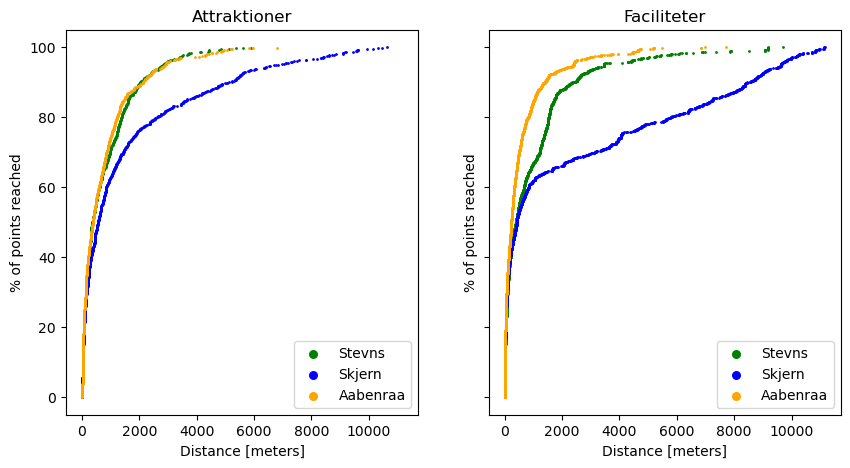

In [118]:
# plot for report
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

for i, pointtype in enumerate(pointtypes):
    for region in regions:
        gdf = gpd.read_file(f"../results/23-03-14-evaluation/{region}_point_{pointtype}.gpkg")
        ax[i].scatter(
            x = sorted(gdf["distance"]), 
            y = [100*y/len(gdf) for y in range(len(gdf))],
            s = 1,
            label = region.capitalize(), 
            color = regions_coldict[region])
    ax[i].set_xlabel("Distance [meters]")
    ax[i].set_ylabel("% of points reached")
    ax[i].set_title(pointtype.capitalize());
    lgd = ax[i].legend()
    lgd.legendHandles[0]._sizes = [30]
    lgd.legendHandles[1]._sizes = [30]
    lgd.legendHandles[2]._sizes = [30]

fig.savefig("../results/23-03-14-evaluation/_overall_points.png", dpi = 300)

**Process line data**

In [114]:
# evaluate and save as gpkg for viz
linetypes = ["cykelrute", "vandrerute"]

for region in regions:

    edges = regions_dict[region]["edges"]
    
    for linetype in linetypes:

        mylines = gpd.read_file(f"../data/processed/{region}/line/{linetype}.gpkg")
        mylines_poly = mylines.buffer(50).unary_union    
        mylines_intersection = edges.intersection(mylines_poly).explode(index_parts=False).reset_index(drop=True)
        mylines_intersection = mylines_intersection[-mylines_intersection.is_empty].reset_index(drop=True)
        mylines_intersection.to_file(f"../results/23-03-14-evaluation/{region}_line_{linetype}.gpkg", index = False)        

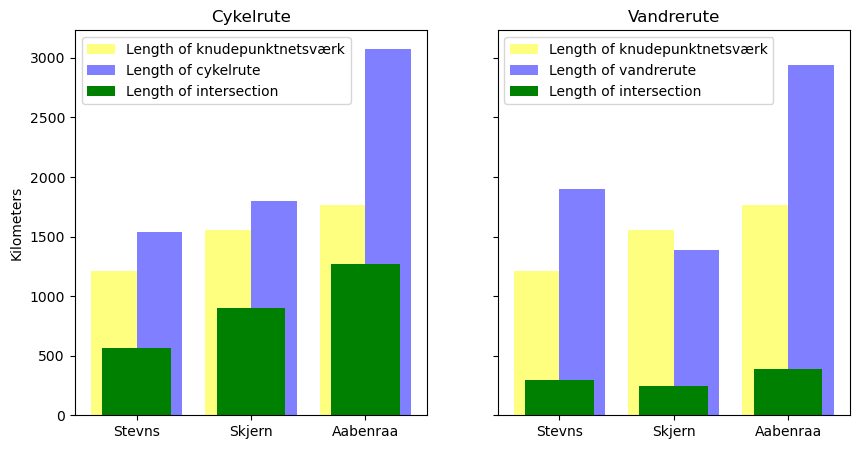

In [117]:
# plot for report 

fig, ax = plt.subplots(1,2, sharex=True, sharey=True,figsize = (10,5))

myticks = np.array([0,1,2])

for j, linetype in enumerate(linetypes):

    len_networks = []
    len_lines = []
    len_inters = []

    for i, region in enumerate(regions):
 
        len_network = regions_dict[region]["edges"].geometry.length.sum() / 1000
        len_networks.append(len_network)

        len_line = gpd.read_file(f"../data/processed/{region}/line/{linetype}.gpkg").geometry.length.sum() / 1000
        len_lines.append(len_line)

        len_inter = gpd.read_file(f"../results/23-03-14-evaluation/{region}_line_{linetype}.gpkg").geometry.length.sum() / 1000
        len_inters.append(len_inter)

    ax[j].bar(
        x = myticks,
        height = len_networks,
        color = "yellow",
        width = 0.4,
        alpha = 0.5,
        label = "Length of knudepunktnetsværk")

    ax[j].bar(
        x = myticks+0.4,
        height = len_lines,
        color = "blue",
        alpha = 0.5,
        width = 0.4,
        label = "Length of " + linetype)
    
    ax[j].bar(
        x = myticks +0.2,
        height = len_inters,
        color = "green",
        width = 0.6,
        label = "Length of intersection"
    )
            
    ax[j].set_xticks(myticks + 0.2)
    ax[j].set_xticklabels([region.capitalize() for region in regions])
    ax[j].set_title(linetype.capitalize())
    ax[j].legend()

ax[0].set_ylabel("Kilometers");

fig.savefig("../results/23-03-14-evaluation/_overall_lines.png", dpi = 300)

**Process polygon data**

In [3]:
areal = gpd.read_file(f"../data/processed/aabenraa/poly/areal.gpkg")

In [5]:
# PROCESS POLY DATA 

# "areal==bad" (where areal use is "teksnisk areal" or "erhverv")
for region in regions:

    edges = regions_dict[region]["edges"]
    areal = gpd.read_file(f"../data/processed/{region}/poly/areal.gpkg")

    # classify data for this network characteristics
    areal["classification"] = 0
    areal.loc[areal["gruppe"]=='Teknisk areal', "classification"] = 1
    areal.loc[areal["type"]=='Erhverv', "classification"] = 1

    areal[areal["classification"]==1].to_file(f"../results/23-03-14-evaluation/{region}_areal_bad.gpkg", index = False)
    areal_poly = areal[areal["classification"]==1].buffer(100).unary_union
    edges_areal_intersect = edges.intersection(areal_poly)
    edges_areal_intersect = edges_areal_intersect.explode(index_parts=False).reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[-edges_areal_intersect.is_empty].reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[edges_areal_intersect.type=="LineString"].reset_index(drop=True)
    edges_areal_intersect.to_file(f"../results/23-03-14-evaluation/{region}_poly_areal_teknisk-erhverv.gpkg", index = False)    

# "areal==summerhouse" (where areal type is sommerhusområde or sommerhusområde skov)
for region in regions:

    edges = regions_dict[region]["edges"]
    areal = gpd.read_file(f"../data/processed/{region}/poly/areal.gpkg")

    # classify data for this network characteristics
    areal["classification"] = 0
    areal.loc[areal["type"]=='Sommerhusområde', "classification"] = 1
    areal.loc[areal["type"]=='Sommerhusområde skov', "classification"] = 1
    areal[areal["classification"]==1].to_file(f"../results/23-03-14-evaluation/{region}_areal_sommerhus.gpkg", index = False)

    areal_poly = areal[areal["classification"]==1].buffer(100).unary_union
    edges_areal_intersect = edges.intersection(areal_poly)
    edges_areal_intersect = edges_areal_intersect.explode(index_parts=False).reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[-edges_areal_intersect.is_empty].reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[edges_areal_intersect.type=="LineString"].reset_index(drop=True)
    edges_areal_intersect.to_file(f"../results/23-03-14-evaluation/{region}_poly_areal_sommerhus.gpkg", index = False)    

# edges in nature
for region in regions:

    edges = regions_dict[region]["edges"]
    nature = gpd.read_file(f"../data/processed/{region}/poly/nature.gpkg")
    nature_poly = nature.buffer(100).unary_union
    edges_areal_intersect = edges.intersection(nature_poly)
    edges_areal_intersect = edges_areal_intersect.explode(index_parts=False).reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[-edges_areal_intersect.is_empty].reset_index(drop=True)
    edges_areal_intersect = edges_areal_intersect[edges_areal_intersect.type=="LineString"].reset_index(drop=True)
    edges_areal_intersect.to_file(f"../results/23-03-14-evaluation/{region}_poly_areal_nature.gpkg", index = False)    

**Make summary statistics**

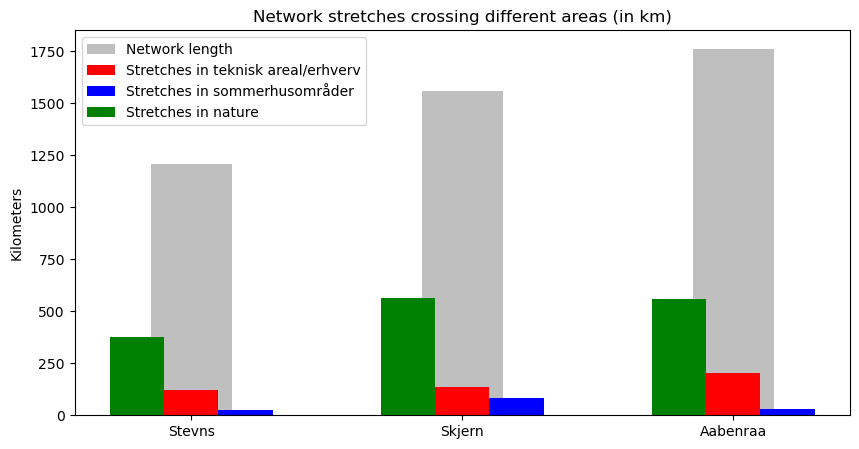

In [158]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

myxticks = np.array([0,1,2])

lens_edges = []
lens_teknisk = []
lens_sommerhus = []
lens_nature = []

for region in regions:
    
    len_edges = regions_dict[region]["edges"].geometry.length.sum() / 1000
    len_teknisk = gpd.read_file(f"../results/23-03-14-evaluation/{region}_poly_areal_teknisk-erhverv.gpkg").geometry.length.sum() / 1000
    len_sommerhus = gpd.read_file(f"../results/23-03-14-evaluation/{region}_poly_areal_sommerhus.gpkg").geometry.length.sum() / 1000
    len_nature = gpd.read_file(f"../results/23-03-14-evaluation/{region}_poly_areal_nature.gpkg").geometry.length.sum() / 1000

    lens_edges.append(len_edges)
    lens_teknisk.append(len_teknisk)
    lens_sommerhus.append(len_sommerhus)
    lens_nature.append(len_nature)
    

ax.bar(
    x = myticks,
    height = lens_edges,
    color = "grey",
    width = 0.3,
    alpha = 0.5,
    label = "Network length"
)

ax.bar(
    x = myticks,
    height = lens_teknisk,
    color = "red",
    width = 0.2,
    label = "Stretches in teknisk areal/erhverv"
)

ax.bar(
    x = myticks + 0.2,
    height = lens_sommerhus,
    color = "blue",
    width = 0.2,
    label = "Stretches in sommerhusområder"
)

ax.bar(
    x = myticks - 0.2,
    height = lens_nature,
    color = "green",
    width = 0.2,
    label = "Stretches in nature"
)

ax.set_xticks(myticks)
ax.set_xticklabels([region.capitalize() for region in regions])
ax.set_ylabel("Kilometers")
ax.legend()
ax.set_title("Network stretches crossing different areas (in km)");

fig.savefig("../results/23-03-14-evaluation/_overall_poly_km.png", dpi = 300)


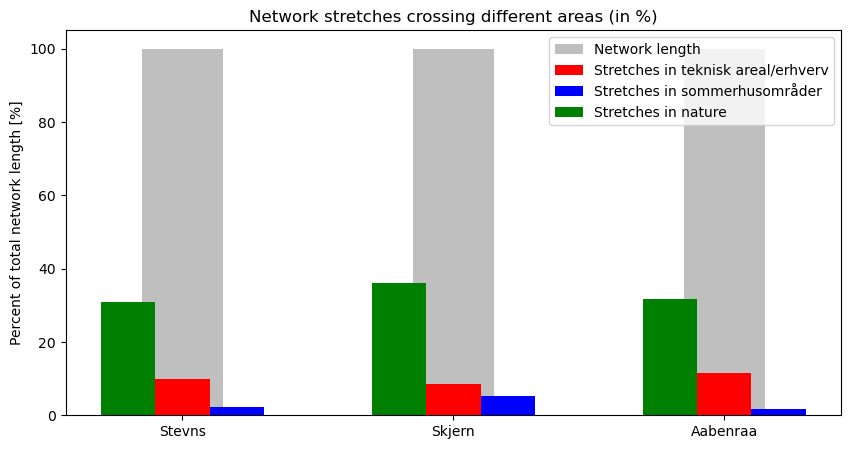

In [159]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(
    x = myticks,
    height = 100 * np.array(lens_edges) / np.array(lens_edges),
    color = "grey",
    width = 0.3,
    alpha = 0.5,
    label = "Network length"
)

ax.bar(
    x = myticks,
    height = 100 * np.array(lens_teknisk) / np.array(lens_edges),
    color = "red",
    width = 0.2,
    label = "Stretches in teknisk areal/erhverv"
)

ax.bar(
    x = myticks + 0.2,
    height = 100 * np.array(lens_sommerhus) / np.array(lens_edges),
    color = "blue",
    width = 0.2,
    label = "Stretches in sommerhusområder"
)

ax.bar(
    x = myticks - 0.2,
    height = 100 * np.array(lens_nature) / np.array(lens_edges),
    color = "green",
    width = 0.2,
    label = "Stretches in nature"
)

ax.set_xticks(myticks)
ax.set_xticklabels([region.capitalize() for region in regions])
ax.set_ylabel("Percent of total network length [%]")
ax.legend()
ax.set_title("Network stretches crossing different areas (in %)");

fig.savefig("../results/23-03-14-evaluation/_overall_poly_pct.png", dpi = 300)
